<a href="https://colab.research.google.com/github/lebe1/ClimateChangeAI/blob/main/Multi-time-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

/home/funny/.virtualenvs/climateChangeAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1 - Modeling

In [2]:
# Import data
df_train = pd.read_csv('scaled_train.csv', sep=';')
df_test = pd.read_csv('scaled_test.csv', sep=';')

In [3]:
df_train.head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
0,1981,1,1,1,-0.848457,-0.648853,-0.465513,-0.609571,-0.556990,-0.549324,...,-0.646738,-0.380941,0.668398,-0.602772,1.202823,0.725221,0.259473,-0.370788,0.564634,0.874327
1,1981,1,2,2,-1.036223,-0.788476,-0.525469,-0.597103,-0.629726,-0.629324,...,-0.572827,-0.877310,0.679110,-0.852623,3.424653,0.725221,0.259473,-0.370788,0.564634,0.874327
2,1981,1,3,3,-0.638602,-0.381243,-0.093786,-0.272918,-0.120574,0.033530,...,-2.494519,-1.824924,0.477628,-1.155472,0.262555,0.725221,0.259473,-0.370788,0.564634,0.874327
3,1981,1,4,4,-0.892638,-0.602312,-0.321619,-0.435011,-0.363027,-0.229326,...,-0.905427,-0.651688,0.435725,-0.837481,0.129450,1.125163,0.259473,-0.370788,0.564634,0.874327
4,1981,1,5,5,-1.257123,-1.044451,-0.729319,-0.971161,-1.017651,-0.880751,...,0.203242,-0.110194,0.540641,-0.746626,0.127744,0.925192,0.259473,-0.370788,0.564634,0.874327


In [4]:
# Create new index based on date columns YYYY-MM
df_train['date'] = pd.to_datetime(dict(year=df_train['YYYY'], month=df_train['MM'], day=df_train['DD']))

# Set date as index
df_train.set_index('date', inplace=True)

# Drop columns
df_train.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

df_train.head()

,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,1,-0.848457,-0.648853,-0.465513,-0.609571,-0.556990,-0.549324,4.117408,-0.214419,0.011780,...,-0.646738,-0.380941,0.668398,-0.602772,1.202823,0.725221,0.259473,-0.370788,0.564634,0.874327
1981-01-02,2,-1.036223,-0.788476,-0.525469,-0.597103,-0.629726,-0.629324,3.384517,-0.116169,0.393698,...,-0.572827,-0.877310,0.679110,-0.852623,3.424653,0.725221,0.259473,-0.370788,0.564634,0.874327
1981-01-03,3,-0.638602,-0.381243,-0.093786,-0.272918,-0.120574,0.033530,4.557143,0.964587,0.521004,...,-2.494519,-1.824924,0.477628,-1.155472,0.262555,0.725221,0.259473,-0.370788,0.564634,0.874327
1981-01-04,4,-0.892638,-0.602312,-0.321619,-0.435011,-0.363027,-0.229326,3.164649,0.080332,0.521004,...,-0.905427,-0.651688,0.435725,-0.837481,0.129450,1.125163,0.259473,-0.370788,0.564634,0.874327
1981-01-05,5,-1.257123,-1.044451,-0.729319,-0.971161,-1.017651,-0.880751,2.798204,-1.884678,0.521004,...,0.203242,-0.110194,0.540641,-0.746626,0.127744,0.925192,0.259473,-0.370788,0.564634,0.874327


In [5]:
# Same for test data
df_test['date'] = pd.to_datetime(dict(year=df_test['YYYY'], month=df_test['MM'], day=df_test['DD']))
df_test.set_index('date', inplace=True)
df_test.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

In [6]:
df_list = []

# Get dataframes from directory
for i in range(0, 100):
    df = pd.read_csv('./df_list/df_' + str(i) + '.csv', sep=';')
    df_list.append(df)

In [7]:
df_list[0].head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,elev,lon,lat
0,1981,1,1,1,1.8,0.5,-1.5,0.8,-1.7,-4.2,...,72,37,96531,0.86,5.76,0.48,0.47,416,4360694,2899423
1,1981,1,2,2,1.7,0.3,-1.6,1.1,-1.3,-4.1,...,55,18,96493,0.25,11.67,0.48,0.47,416,4360694,2899423
2,1981,1,3,3,5.5,4.0,2.4,4.9,3.0,1.0,...,63,9,95054,0.40,20.14,0.49,0.47,416,4360694,2899423
3,1981,1,4,4,2.7,1.2,-2.0,1.5,-0.3,-5.1,...,75,43,94903,0.85,5.39,0.50,0.48,416,4360694,2899423
4,1981,1,5,5,-0.1,-1.6,-2.6,-3.4,-5.3,-6.8,...,68,43,95956,0.64,4.56,0.49,0.48,416,4360694,2899423


In [8]:
for index, df in enumerate(df_list):
   # Create new index based on date columns YYYY-MM
    df['date'] = pd.to_datetime(dict(year=df['YYYY'], month=df['MM'], day=df['DD']))

    # Set date as index
    df.set_index('date', inplace=True)

    df = df.asfreq('D')

    # Drop columns
    df.drop(['YYYY', 'MM', 'DD'], axis=1, inplace=True)

    df_list[index] = df

print(df_list[0].index.freq)
# df_list[0].head()

<Day>


In [9]:
df_prec = pd.DataFrame()
# Iterate over df_list
for index, df in enumerate(df_list):
    # For each dataframe, create a new prec column
    df_prec['prec_' + str(index)] = df['prec']

df_prec.head()

,prec_0,prec_1,prec_2,prec_3,prec_4,prec_5,prec_6,prec_7,prec_8,prec_9,...,prec_90,prec_91,prec_92,prec_93,prec_94,prec_95,prec_96,prec_97,prec_98,prec_99
date,,,,,,,,,,,,,,,,,,,,,
1981-01-01,5.76,6.94,0.50,8.81,7.90,10.43,9.69,6.98,8.28,0.73,...,0.37,6.33,5.20,8.48,5.85,4.86,8.12,1.27,4.22,7.76
1981-01-02,11.67,13.20,1.33,15.17,14.63,21.58,17.60,16.52,13.15,1.63,...,1.10,14.26,7.50,14.07,12.84,12.46,13.15,2.08,12.10,13.41
1981-01-03,20.14,14.90,5.94,10.13,16.71,15.36,16.12,24.62,9.20,5.86,...,4.71,12.80,8.10,9.87,8.89,17.63,9.68,8.03,18.18,23.89
1981-01-04,5.39,8.08,0.29,16.22,29.04,22.47,33.54,13.18,21.51,0.91,...,0.22,36.29,4.04,18.08,9.65,5.14,23.61,0.93,6.19,7.09
1981-01-05,4.56,8.43,1.80,15.77,18.22,11.57,20.90,6.22,15.83,2.83,...,1.89,11.84,9.51,17.48,16.51,4.58,17.02,2.29,3.75,5.65


In [10]:
# Split in train and test
# ==============================================================================

line_for_70pct = round(len(df_prec) * 0.7)

data_train = df_prec.iloc[:line_for_70pct, :]
data_test  = df_prec.iloc[line_for_70pct:, :]


print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1981-01-01 00:00:00 --- 2008-04-19 00:00:00   (n=9971)
Test dates  : 2008-04-20 00:00:00 --- 2019-12-31 00:00:00   (n=4273)


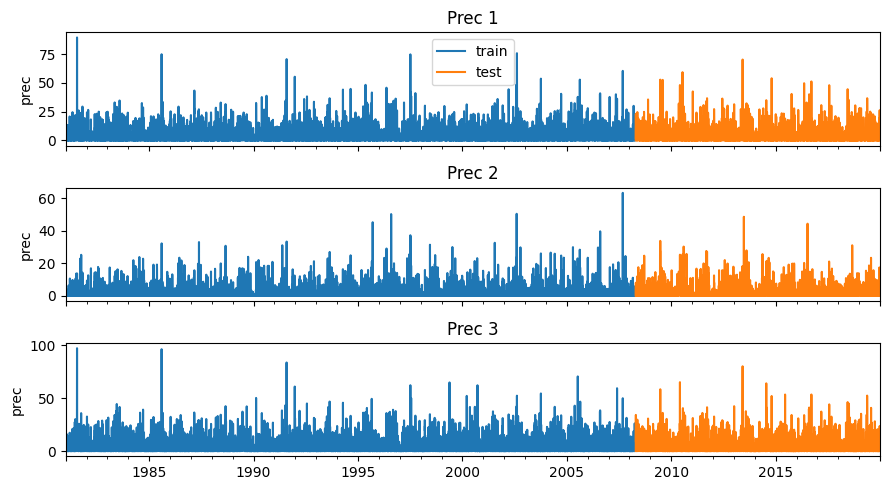

In [11]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['prec_1'].plot(label='train', ax=axes[0])
data_test['prec_1'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('prec')
axes[0].set_title('Prec 1')
axes[0].legend()

data_train['prec_2'].plot(label='train', ax=axes[1])
data_test['prec_2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('prec')
axes[1].set_title('Prec 2')

data_train['prec_3'].plot(label='train', ax=axes[2])
data_test['prec_3'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('prec')
axes[2].set_title('Prec 3')

fig.tight_layout()
plt.show()

In [13]:
#from xgboost import XGBRegressor
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = Ridge(random_state=123),
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 forecaster_id      = None
             )

forecaster.fit(series=data_train, exog=None)
forecaster

ForecasterAutoregMultiSeries 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Window size: 24 
Series levels (names): ['prec_0', 'prec_1', 'prec_2', '

In [20]:
# Predict and predict_interval
# ==============================================================================
steps = 1

# Get


# Predictions for prec_0
predictions_prec_all = forecaster.predict(steps=steps)
display(predictions_prec_all.head(3))


,prec_0,prec_1,prec_2,prec_3,prec_4,prec_5,prec_6,prec_7,prec_8,prec_9,...,prec_90,prec_91,prec_92,prec_93,prec_94,prec_95,prec_96,prec_97,prec_98,prec_99
2008-04-20,6.727702,4.991061,4.732454,6.400641,4.822399,5.888894,5.532484,4.977527,4.493559,3.202866,...,3.311719,4.703293,4.172869,6.814248,5.77218,5.248816,6.158211,3.966284,4.28209,5.812128


In [21]:
# The root mean squared error (RMSE), parameter squared=False gives the RMSE
print("Root mean squared error: %.2f"
      % mean_squared_error(data_test[:1], predictions_prec_all, squared=False))

Root mean squared error: 4.61


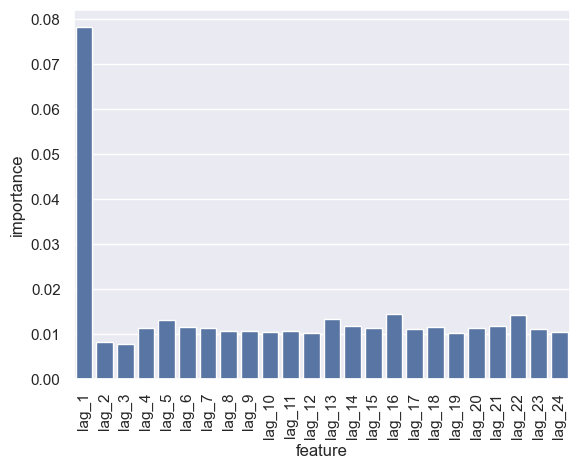

In [32]:
feature_importance = forecaster.get_feature_importances()

# Plot feature importance by using only lags

lags = feature_importance[:24]

# plt.bar(x=lags['feature'], height=lags['importance'])
sns.set_theme()
sns.barplot(x=lags['feature'], y=lags['importance'])
# Set x labels vertically
plt.xticks(rotation=90)
plt.show()

# Export analysing data

In [43]:
# Create empty dataframe
df = pd.DataFrame()

# Create rmse column
df['rmse'] = np.nan

# Add root mean squared error
df.loc[0] = mean_squared_error(data_test[:1], predictions_prec_all, squared=False)

df.head()


,rmse
0,4.610456


### Export to csv file

In [44]:
df.to_csv('time_series_model_feature_importance.csv', sep=';', index=False)